In [2]:
import torch
from torchdiffeq import odeint as odeint


from mpc import mpc
from mpc.mpc import QuadCost, LinDx, GradMethods
from mpc.env_dx import hri
from mpc.util import band_limited_noise, sample_from_data, read_double_column_csv

import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt

import os
import io
import base64
import tempfile
from IPython.display import HTML

from tqdm import tqdm

%matplotlib inline

def get_desired_angle(t, joint="Knee", modality="Angle"):
    filename = None
    output = None
    if joint == "Sine":
        return - np.pi/4 * np.cos(2*np.pi*t)- np.pi/4
    elif joint == "Knee" and modality == "Angle":
        filename = ("../data/20221219_BioKneeAngleTableBase.csv")
        data = read_double_column_csv(filename)
        data_freq = 83
        output = torch.tensor([sample_from_data(t[i], data, freq=data_freq) for i in range(len(t))])
        output = output * np.pi / 180
    elif joint == "Knee" and modality == "Torque":
        filename = ("../data/20221219_BioKneeTorqueTableBase.csv")
        data = read_double_column_csv(filename)
        data_freq = 83
        output = torch.tensor([sample_from_data(t[i], data, freq=data_freq) for i in range(len(t))])
        output = output
    
    return output

def get_reference_angle(ts_cur, ts_pre, dt, joint):
    """Get the reference angle at time t for the specified joint.
    ts_cur: int - the time step set, starting with the current step, length of T (MPC horizon)
    ts_pre: int - the time step set, starting with the (time delay) steps ahead, length of T (MPC horizon)
    dt: float - the sampling period
    joint: str - the joint to get the reference angle for
        "Sine" - a sine wave
        "Knee" - the knee joint
    """
    des_angle = get_desired_angle(ts_cur * dt, joint=joint, modality="Angle")
    des_vel = (get_desired_angle(ts_cur * dt, joint=joint, modality="Angle") - get_desired_angle(ts_pre * dt, joint=des_traj_joint, modality="Angle")) / dt
    return des_angle, des_vel

def get_human_disturbance(ts, dt, joint, weight, level):
    """Get the human disturbance at time t for the specified joint.
    t: int - the time step
    joint: str - the joint to get the human disturbance
        "Sine" - a sine wave
        "Knee" - the knee joint
    weight: float - the bodyweight of the human
    level: float - the percentage of the full joint torque at given bodyweight
    """
    human_u = - weight * level * get_desired_angle(ts * dt, joint=joint, modality="Torque")
    return human_u

In [8]:
def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

torch.manual_seed(0)
q1 = uniform(n_batch, 0.5*np.pi, 0.5*np.pi)
h_q2 = uniform(n_batch, -0.5*np.pi, -0.5*np.pi)
r_d2 = uniform(n_batch, 0., 0.)
r_d3 = uniform(n_batch, 0., 0.)
r_q4 = uniform(n_batch, 0., 0.)
r_q5 = uniform(n_batch, -0.5*np.pi, -0.5*np.pi)
dq1 = uniform(n_batch, 0., 0.)
h_dq2 = uniform(n_batch, 0., 0.)
r_dd2 = uniform(n_batch, 0., 0.)
r_dd3 = uniform(n_batch, 0., 0.)
r_dq4 = uniform(n_batch, 0., 0.)
r_dq5 = uniform(n_batch, 0., 0.)
q1

tensor([1.5708])

In [29]:
# Dempster et al. model from @Hwang2015
# For a subject
# - weight = 75 kg
# - thigh length = 0.4 m
# - shank length = 0.4 m

params = {
        "m1": 7.275,
        "m2": 3.75,
        "m3": 2,
        "m4": 2,
        "g": 10,
        "I_G1z": 0.121,
        "I_G2z": 0.055,
        "I_G3z": 0.02,
        "I_G4z": 0.02,
        "l1": 0.4,
        "l2": 0.4,
        "l3": 0.2,
        "l4": 0.4,
        "lc1": 0.173,
        "la1": 0.2,
        "lb1": 0.2,
        "lc2": 0.173,
        "lc3": 0.1,
        "lc4": 0.2,
        "la4": 0.2,
        "la2": 0.2,
        "K_AFz": 6000,
        "K_AFx": 3000,
        "K_AMy": 50,
        "K_BFz": 6000,
        "K_BFx": 3000,
        "K_BMy": 50,
        "K_AFzN3": 60000*5,
        "K_AFxN3": 30000*5,
        "K_AMyN3": 100*5,
        "K_BFzN3": 60000*5,
        "K_BFxN3": 30000*5,
        "K_BMyN3": 100*5,
        "K_CFz": 24000,
        "K_CFx": 12000,
        "K_CMy": 20,
        "D_AFz": 100,
        "D_AFx": 100,
        "D_AMy": 10,
        "D_BFz": 100,
        "D_BFx": 100,
        "D_BMy": 10,
        "D_CFz": 100,
        "D_CFx": 100,
        "D_CMy": 10,
    }

params_wrong = {
        "m1": 5.275,
        "m2": 2.75,
        "m3": 2,
        "m4": 2,
        "g": 10,
        "I_G1z": 0.101,
        "I_G2z": 0.045,
        "I_G3z": 0.02,
        "I_G4z": 0.02,
        "l1": 0.4,
        "l2": 0.4,
        "l3": 0.2,
        "l4": 0.2,
        "lc1": 0.173,
        "la1": 0.2,
        "lb1": 0.2,
        "lc2": 0.173,
        "lc3": 0.1,
        "lc4": 0.1,
        "la4": 0.2,
        "la2": 0.2,
        "K_AFz": 4000,
        "K_AFx": 6000,
        "K_AMy": 20,
        "K_BFz": 4000,
        "K_BFx": 3000,
        "K_BMy": 20,
        "D_AFz": 100,
        "D_AFx": 100,
        "D_AMy": 10,
        "D_BFz": 100,
        "D_BFx": 100,
        "D_BMy": 10,
    }

# Set the parameters for the MPC
n_batch, T, mpc_T = 1, 120, 5
sample_period = 0.01

# Add band-limited white noise to sensor readings
band_upper = 300
band_lower = 0
noise_level = 0.4
sampling_rate = 1 / sample_period  # Hz
duration = T * sample_period  # second
blnoise = band_limited_noise(band_lower, band_upper, samples=int(duration*sampling_rate), samplerate=sampling_rate, noise_level=noise_level)

# Define the HRI system
dx = hri.HRIDx(model_params=params, dt=sample_period)
dx_wrong = hri.HRIDx(model_params=params_wrong, dt=sample_period)

# Define the initial state and input
q1 = torch.tensor([0.5*torch.pi])
h_q2 = torch.tensor([-0.0*torch.pi])
r_d2 = torch.tensor([0.])
r_d3 = torch.tensor([0.0044])
r_q4 = torch.tensor([0.])
r_q5 = torch.tensor([-0.0*torch.pi])
dq1 = torch.tensor([0.])
h_dq2 = torch.tensor([0.])
r_dd2 = torch.tensor([0.])
r_dd3 = torch.tensor([0.])
r_dq4 = torch.tensor([0.])
r_dq5 = torch.tensor([0.])

xinit = torch.stack((q1, dq1, h_q2, h_dq2, r_d2, r_dd2, r_d3, r_dd3, r_q4, r_dq4, r_q5, r_dq5), dim=1)
u_init = None


# Specify the controller
controller = 'mpc'

if controller == 'mpc':
    pass
elif controller == 'pid':
    accumu_err = 0
else:
    raise ValueError('Invalid controller')

# initialise an array to store the state and action trajectories
bodyweight = 75
bio_torque_level = 0.1
des_traj_joint = "Knee"
delay_step = 0
x = xinit  # assign initial state
x_traj = torch.zeros(T, dx.n_state)
u_traj = torch.zeros(T, dx.n_ctrl)
t_dir = tempfile.mkdtemp()
print('Tmp dir: {}'.format(t_dir))
for t in tqdm(range(T)):
    # Generate the reference angle and human disturbance
    t_collection = torch.tensor([i for i in range(t, t+mpc_T)])
    t_collection_pre = np.maximum(t_collection-delay_step, 0)
    des_angle, des_vel = get_reference_angle(t_collection, t_collection_pre, dt=dx.dt, joint=des_traj_joint)
    human_u = get_human_disturbance(t_collection, dt=dx.dt, joint=des_traj_joint, weight=bodyweight, level=bio_torque_level)
    dx.update_input(human_u)
    
    # Generate sensor readings
    x_traj[t] = x
    actual_angle = x_traj[t, 2] + blnoise[t]
    actual_vel = ((x_traj[t,2]+blnoise[t] - x_traj[t-1,2] - blnoise[t-1]) / dx.dt) if t > 0 else 0
    actual_vel = x_traj[t,3]

    actual_angle_delayed = x_traj[t-delay_step, 2] + blnoise[t-delay_step] if t > 0 else xinit[0, 2]
    actual_vel_delayed = ((x_traj[t-delay_step,2] + blnoise[t-delay_step] - x_traj[t-delay_step-1,2] - blnoise[t-delay_step-1]) / dx.dt) if t > delay_step else 0
    actual_vel_delayed = x_traj[t-delay_step,3] if t > delay_step else 0
    
    if controller == 'mpc':
        goal_weights = torch.Tensor((0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.))
        goal_states = torch.zeros(mpc_T, dx.n_state)
        pxs = torch.zeros(mpc_T, dx.n_state)
        ps = torch.zeros(mpc_T, dx.n_state + 1)
        for i in range(mpc_T):
            goal_states[i, 0] = np.pi/2
            goal_states[i, 2] = des_angle[i]
            goal_states[i, 10] = des_angle[i]
            pxs[i, :] = -torch.sqrt(goal_weights)*goal_states[i, :]
            ps[i, :] = torch.cat((pxs[i, :], torch.zeros(dx.n_ctrl)))
        ctrl_penalty = 0.00001
        q = torch.cat((
            goal_weights,
            ctrl_penalty*torch.ones(dx.n_ctrl)
        ))
        Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
            mpc_T, n_batch, 1, 1
        )
        # Make the dimensions of p and Q match
        p = ps.unsqueeze(1).expand(-1, n_batch, -1)

        dx.update_goal(goal_states[0, :], goal_weights, ctrl_penalty)
        
        nominal_states, nominal_actions, nominal_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_init=u_init,
            u_lower=dx.lower, u_upper=dx.upper,
            lqr_iter=50,
            verbose=0,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=dx.linesearch_decay,
            max_linesearch_iter=dx.max_linesearch_iter,
            grad_method=GradMethods.FINITE_DIFF,
            eps=1e-2,
        )(x, QuadCost(Q, p), dx)
        
        # shift the actions one step forward as the initial guess for the next step
        next_action = nominal_actions[0]
        u_init = torch.cat((nominal_actions[1:], torch.zeros(1, n_batch, dx.n_ctrl)), dim=0)
        u_init[-2] = u_init[-3]  # no idea what this does
    
    elif controller == 'pid':
        pid_p = 500
        pid_i = 50
        pid_d = 15
        # a pid controller to balance the pendulum
        des_angle_pid = des_angle[0]
        des_vel_pid = des_vel[0]
        accumu_err += (actual_angle_delayed - des_angle_pid) * dx.dt
        next_action = - pid_p*(actual_angle_delayed - des_angle_pid) - pid_d*(actual_vel_delayed - des_vel_pid) - pid_i*accumu_err
        next_action = torch.clamp(next_action, -24, 24)   
        next_action = torch.tensor([[next_action]]) 
    else:
        raise ValueError('Invalid controller') 
    
    ts = torch.tensor([0, dx.dt])
    model = hri.HRIDx_Sim(model_params=params, u=next_action, current_t=t, dt=sample_period)
    model.update_input(human_u)
    x = odeint(model, x, ts, method='dopri5').detach().numpy()
    x = torch.tensor(x[-1, :, :])
    
    # save the state and action trajectories
    x_traj[t] = x
    u_traj[t] = next_action

    #fig.savefig(os.path.join(t_dir, '{:03d}.png'.format(t)))
    #plt.close(fig)

Tmp dir: /var/folders/ch/glb2rc_j5bzc2h7ggs8xj_w40000gp/T/tmpp84eq80f


100%|██████████| 120/120 [02:58<00:00,  1.49s/it]


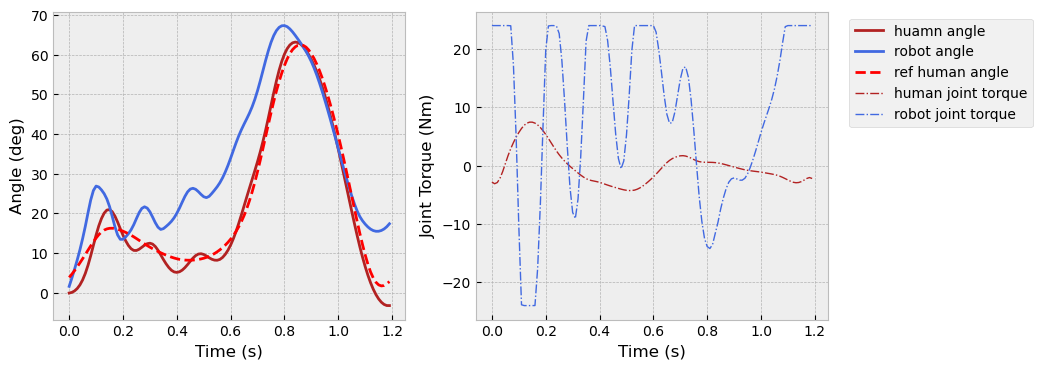

In [30]:
des_angle, vel = get_reference_angle(np.arange(T), np.arange(T), dt=dx.dt, joint=des_traj_joint)
human_u = get_human_disturbance(np.arange(T), dt=dx.dt, joint=des_traj_joint, weight=bodyweight, level=bio_torque_level)


# create an array for the time steps
t = np.arange(T) / 100
fig = plt.figure(figsize=(10,4))

for i in range(n_batch):
    ax = fig.add_subplot(1, 2, 1)
    
    # Plotting on the primary y-axis
    ax.plot(t, x_traj[:, 2] * 180/np.pi, color='firebrick')  # h th
    ax.plot(t, x_traj[:, 10] * 180/np.pi, color='royalblue')  # r th
    ax.plot(t, des_angle * 180/np.pi, 'r--')  # ref
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Angle (deg)', color='black')
    ax.tick_params(axis='y', labelcolor='black')
    
    # add another subplot
    ax = fig.add_subplot(1, 2, 2)  
    ax.plot(t, human_u, color='firebrick', linestyle='-.', linewidth=1)  # human u
    ax.plot(t, u_traj[:, 0].detach().numpy(), color='royalblue', linestyle='-.', linewidth=1)  # u1
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Joint Torque (Nm)', color='black')  
    ax.tick_params(axis='y', labelcolor='black')
    
    # Adding a legend by creating custom lines and labels
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='firebrick', linestyle='-'),
                    Line2D([0], [0], color='royalblue', linestyle='-'),
                    Line2D([0], [0], color='r', linestyle='--'),
                    Line2D([0], [0], color='firebrick', linestyle='-.', linewidth=1),
                    Line2D([0], [0], color='royalblue', linestyle='-.', linewidth=1)]
    
    ax.legend(custom_lines, ['huamn angle', 'robot angle', 'ref human angle', 'human joint torque', 'robot joint torque'], bbox_to_anchor=(1.6, 1), loc='upper right')
#plt.savefig('../results/MPC_CorrectModel_Sine.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
vid_fname = 'pendulum-{}.mp4'.format(mode)

if os.path.exists(vid_fname):
    os.remove(vid_fname)
    
cmd = 'ffmpeg -r 16 -f image2 -i {}/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(
    t_dir, vid_fname
)

os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [4]:
a = torch.tensor([20., 30., 40., 50., 60., 70., 80., 90., 100., 110.])
a[-3]

tensor(90.)

In [20]:
t = 1
t_collection = torch.tensor([i for i in range(t, t+5)])
t_collection-2
t_collection_pre = np.maximum(t_collection-2, 0)
t_collection_pre

tensor([0, 0, 1, 2, 3])